Program to find labels of a single image with saved model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-9-92208d26ce5d>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(current_dir, 'best_model.pth'), map_location=t

Predicted Vehicle Type: CONVERTIBLE
Predicted Vehicle Type: 1
Predicted Vehicle Color: red
Classification took: 0.250s


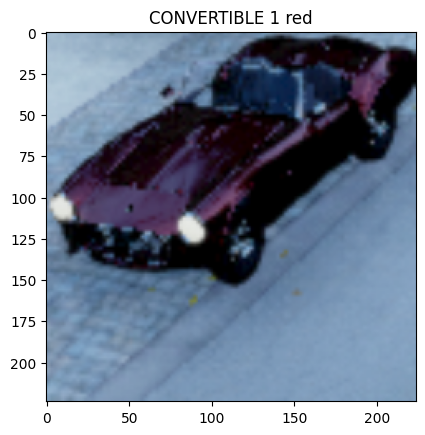

In [9]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import numpy as np
import time
import os
from google.colab import drive
drive.mount('/content/drive')

# Note: When done on GPU, results are <30ms

# most things here are the same as other program
current_dir = '/content/drive/MyDrive/Colab/Project/Model'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # cpu training is slow, use GPU if available
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 23)
)
_ = model.to(device) # move to GPU
model.load_state_dict(torch.load(os.path.join(current_dir, 'best_model.pth'), map_location=torch.device('cpu')))
model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# load our encoded labels
with open(os.path.join(current_dir, 'vt_encoder.pkl'), 'rb') as f:
    vt_encoder = pickle.load(f)

with open(os.path.join(current_dir, 'vst_encoder.pkl'), 'rb') as f:
    vst_encoder = pickle.load(f)

with open(os.path.join(current_dir, 'vc_encoder.pkl'), 'rb') as f:
    vc_encoder = pickle.load(f)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# function to make predictions
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)
    input_tensor = input_tensor.to('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        outputs = model(input_tensor)

        vehicle_type_preds = outputs[:, :len(vt_encoder.classes_)].argmax(dim=1) # 21 different classes, 0-11 are the Types/Subtypes
        vehicle_stype_preds = outputs[:, len(vt_encoder.classes_):len(vt_encoder.classes_) + len(vst_encoder.classes_)].argmax(dim=1)
        vehicle_color_preds = outputs[:, len(vt_encoder.classes_) + len(vst_encoder.classes_):].argmax(dim=1) # 12-20 are the colors

        vehicle_type = vt_encoder.inverse_transform([vehicle_type_preds.item()])[0]
        vehicle_stype = vst_encoder.inverse_transform([vehicle_stype_preds.item()])[0]
        vehicle_color = vc_encoder.inverse_transform([vehicle_color_preds.item()])[0]
    return vehicle_type, vehicle_stype, vehicle_color

image_path = os.path.join(current_dir, '1.png')

stime = time.time() # start timer

vehicle_type, vehicle_stype, vehicle_color = classify_image(image_path)

etime = time.time() # end timer, classification done
ttime = etime - stime
print(f'Predicted Vehicle Type: {vehicle_type}')
print(f'Predicted Vehicle Type: {vehicle_stype}')
print(f'Predicted Vehicle Color: {vehicle_color}')
print(f'Classification took: {ttime:.3f}s')

# show the image with the predictions
def imshow(img, title):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

image = Image.open(image_path).convert("RGB")
input_tensor = transform(image)
imshow(input_tensor, f'{vehicle_type} {vehicle_stype} {vehicle_color}')